In [2]:
import numpy as np 
import numpy.ma as ma
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import datetime

from tqdm import tqdm



import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
import glob
import pandas as pd
from astropy.table import Table



matplotlib.rcParams.update({'xtick.labelsize':18,
                            'ytick.labelsize':18,
                            'axes.titlesize':18,
                            'axes.labelsize':18,
                            'font.size':18,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif'})

flags = ['BADPIX',
'CRPIX',
'SATPIX',
'UNFIXABLE',
'BADDARK',
'BADFLAT',
'BADERR',
'NOSKY',
'LITTROW_GHOST',
'PERSIST_HIGH',
'PERSIST_MED',
'PERSIST_LOW',
'SIG_SKYLINE',
'SIG_TELLURIC']


from TolColors import tol_cmap
cmap = tol_cmap('rainbow_PuRd')
cmap_diverge = tol_cmap('sunset')

In [3]:
hdulist = fits.open('ResidualsFiles/CACLOUD/CA_TEST_Residuals.fits')
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)
select_bitmasked = np.where((np.bitwise_and(stars['ASPCAPFLAG'], 23) == 0) | 
                            (np.bitwise_and(stars['ASPCAPFLAG'], 19) == 0))[0]

stars = stars[select_bitmasked]

stars = stars[np.where((stars['TEFF_ERR'] < 600) & (stars['LOGG_ERR'] < 0.5) & (stars['M_H_ERR'] < 0.3))[0]]

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [4]:
def getwavs_(hdu):
    header = hdu.header
    CRVAL1 = header['CRVAL1']
    CDELT1 = header['CDELT1']
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(len(hdu.data[0,:])))
    return wavs 

In [5]:
teff_bins = np.concatenate([np.arange(3000, 5000, 250), np.arange(5000,10000, 500), [10000]]) # or whatever
logg_bins = np.arange(-1, 5.1, 0.5)
m_h_bins = np.concatenate([np.arange(-2.5, 1.0, .3), [1]])
print(len(teff_bins), len(logg_bins), len(m_h_bins))
print((len(teff_bins)-1) * (len(logg_bins)-1) * (len(m_h_bins)-1))
print(len(hdulist[1:]))

19 13 13
2592
2592


In [6]:
hdus = np.array(hdulist[1:]).reshape(18, 12,12)

In [7]:
def match_residual(teff, logg, m_h):
    teff_bins = np.concatenate([np.arange(3000, 5000, 250), np.arange(5000,10000, 500), [10000]]) # or whatever
    logg_bins = np.arange(-1, 5.1, 0.5)
    m_h_bins = np.concatenate([np.arange(-2.5, 1.0, .3), [1]])

    i = np.searchsorted(teff_bins, teff)
    j = np.searchsorted(logg_bins, logg)
    k = np.searchsorted(m_h_bins, m_h)
    
    return hdus[i,j,k]

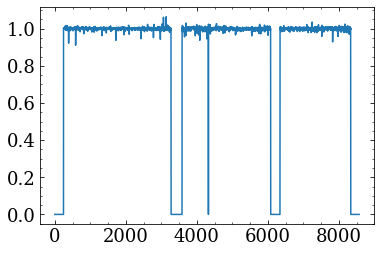

In [8]:
plt.plot(match_residual(6000,4, 0.015).data[0,:])
plt.show()

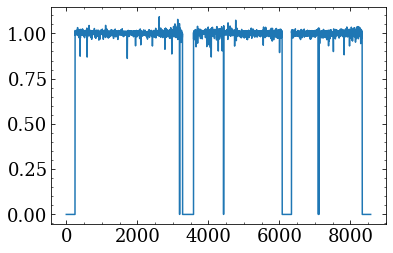

In [9]:
plt.plot(match_residual(5000, 4, 0.015).data[0,:])
plt.show()

In [10]:
testfile = fits.open('ResidualsFiles/Residuals_teffbin3250-3300.fits')
testfile = np.array(testfile[1:]).reshape(30, 12)


def match(hdulist, logg, m_h):
    logg_bins = np.arange(-1, 5.2, 0.2)
    m_h_bins = np.concatenate([np.arange(-2.3, -1.1, 0.3), np.arange(-1.1, 0.5, 0.2), [0.5]])
    j = np.searchsorted(logg_bins, logg)
    k = np.searchsorted(m_h_bins, m_h)
    
    return hdulist[j,k]

In [63]:
def plot_residual(hdu, ax = None):
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize = (12,8))
    residual = hdu.data[0,:]
    errs = hdu.data[1, :]
    
    lmbda = getwavs_(hdu)
    ax.plot(lmbda, residual, label = 'Binned Residual')
    ax.plot(lmbda, residual + errs)
    ax.set_ylim(0.8, 1.2)
    ax.set_xlim(15250, 15500)
    ax.set_xlim()
    return fig, ax, lmbda
#     plt.show()
    
# hduu = match(testfile, 0.4, 0.1)
# print(hduu.header['NBIN'])
# plot_residual(hduu)
# plt.show()

In [50]:
def getspecpaths(tab):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(tab['TELESCOPE'], dtype = str)
    field = np.array(tab['FIELD'], dtype = str)
    sourceid = np.array(tab['APOGEE_ID'], dtype = str)
    length = len(sourceid)
    path = tuple((specdir + specname).format(TELESCOPE = telescope[i], FIELD = field[i], SOURCEID = sourceid[i]) 
                 for i in range(length))
    return path

def match_all(teff, logg, m_h):
    teff_bins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
    logg_bins = np.arange(-1, 5.2, 0.2)
    m_h_bins = np.concatenate([np.arange(-2.3, -1.1, 0.3), np.arange(-1.1, 0.5, 0.2), [0.5]])
    
    i = int(np.searchsorted(teff_bins, teff))
    j = np.searchsorted(logg_bins, logg)
    k = np.searchsorted(m_h_bins, m_h)
    
#     teff_min, teff_max = int(teff_bins[i]), int(teff_bins[i+1])
    
    if teff < 4500:
        binnedres_fname = 'ResidualsFiles/Residuals_teffbin{low}-{high}.fits'.format(low=teff_bins[i-1], 
                                                                                high =teff_bins[i])
    else:
        binnedres_fname = 'ResidualsFiles/remake/Residuals_teffbin{low}-{high}.fits'.format(low=teff_bins[i-1], 
                                                                                 high =teff_bins[i])
                                    #THESE INDICES NEED SOME SAFETY CHECKS
            
#     print(binnedres_fname)
    binnedres_hdulist = fits.open(binnedres_fname)
    binnedres_hdulist = np.array(binnedres_hdulist[1:]).reshape(30, 12)
    binnedres = binnedres_hdulist[j-1, k-1]
    return binnedres

In [51]:
hightemp = stars[np.where(stars['TEFF'] > 6500)]
lowlogg = stars[np.where(stars['LOGG'] < 1)]


3723.9111 0.9045983 -0.14768


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


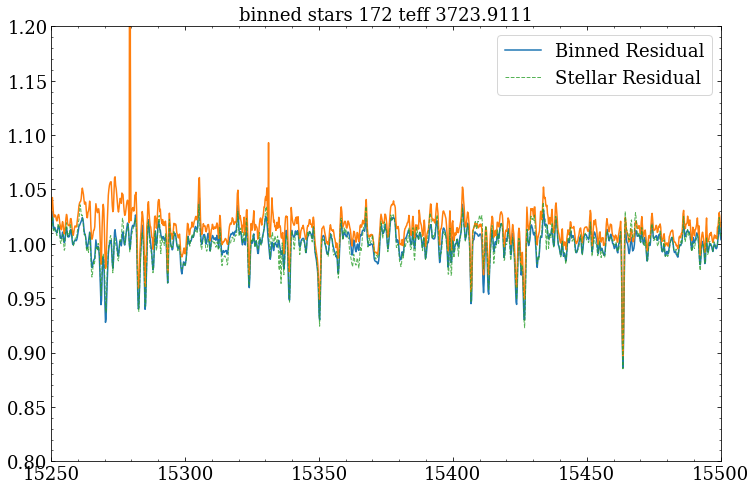

In [65]:
a = 0 # 0 # 10 # 1000
# hightemp = stars[np.where(stars['TEFF'] > 6500)]
star = stars[a:a+1] # ignore the weird indexing for now!
# star = hightemp[a:a+1]

# a = 10000
# star = lowlogg[a:a+1]

def compare(star):
    teff, logg, m_h = (star['TEFF'].data[0], star['LOGG'].data[0], star['M_H'].data[0])
#     teff = 5950
#     logg = 3
#     m_h = 0
    print(teff, logg, m_h)
    spec_hdulist = fits.open(getspecpaths(star)[0])
    residual = spec_hdulist[1].data / spec_hdulist[3].data
    
    binned_residual = match_all(teff, logg, m_h)
    nstars = binned_residual.header['NBIN']
    
#     print(binned_residual.data)
    fig, ax, wavs = plot_residual(binned_residual)
    ax.plot(wavs, residual, linestyle = 'dashed', linewidth  = 1, alpha = 0.8, label = 'Stellar Residual')
    ax.set_title('binned stars ' + str( nstars) + ' teff ' + str (teff))
    ax.legend()
    
    plt.show()
    
compare(star)

In [37]:
teff_bins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
logg_bins = np.arange(-1, 5.2, 0.2)
m_h_bins = np.concatenate([np.arange(-2.3, -1.1, 0.3), np.arange(-1.1, 0.5, 0.2), [0.5]])
teff_bins[np.searchsorted(teff_bins, 5950, 'left')]

6050

9950